### gpu configuration

In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"

if physical_devices:
    # Restrict Tensorflow to only use the first GPU
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(physical_devices), "Physical GPUs, ", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        #Visible devices must be set before GPUs have been initialized.
        print(e)

2 Physical GPUs,  1 Logical GPU


2023-01-15 21:11:40.884110: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 21:11:41.483249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:91:00.0, compute capability: 7.5


### import libraries

In [2]:
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import cv2

In [3]:
# configs 
BS=16
val_split = 0.2
test_split=0.25

### prepare train, test, split

In [4]:
train_df = pd.read_csv("new_train.csv")
train_df.head()

Unnamed: 0  site_id  patient_id    image_id laterality view   age  cancer  \
0          87        1       10130   388811999          L  MLO  71.0       1   
1          88        1       10130   613462606          L   CC  71.0       1   
2          89        1       10130  1360338805          L   CC  71.0       1   
3          90        1       10130  1672636630          L  MLO  71.0       1   
4          91        1       10130  1013166704          R   CC  71.0       0   

   biopsy  invasive  BIRADS  implant density  machine_id  \
0       1         1     0.0        0       B          49   
1       1         1     0.0        0       B          49   
2       1         1     0.0        0       B          49   
3       1         1     0.0        0       B          49   
4       0         0     NaN        0       B          49   

   difficult_negative_case  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [5]:
train_df.drop("Unnamed: 0", axis=1, inplace=True)
train_df['path'] =train_df['patient_id'].astype(str) +'/'+train_df['image_id'].astype(str)+'.png'
train_df['lat_view'] = train_df['laterality']+"_"+train_df['view']
train_df.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        1       10130   388811999          L  MLO  71.0       1       1   
1        1       10130   613462606          L   CC  71.0       1       1   
2        1       10130  1360338805          L   CC  71.0       1       1   
3        1       10130  1672636630          L  MLO  71.0       1       1   
4        1       10130  1013166704          R   CC  71.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         1     0.0        0       B          49                    False   
1         1     0.0        0       B          49                    False   
2         1     0.0        0       B          49                    False   
3         1     0.0        0       B          49                    False   
4         0     NaN        0       B          49                    False   

                   path lat_view  
0   10130/388811999.png    L_MLO  
1   10130/613462606.png     L_CC  
2  10130/1360338805.png     L_CC  
3  10130/1672636630.png    L_MLO  
4  10130/1013166704.png     R_CC

In [6]:
imgs_paths = []
pairs_paths = []
labels = []
base_dir = 'train_images_processed'
for patient_id in os.listdir(base_dir):
    case_df = train_df[train_df['patient_id']==int(patient_id)]
    case_labels = case_df['cancer'].values
    if 1 in case_labels:
        label=1
    else:
        label=0
    L_MLO =  case_df[case_df['lat_view'] == 'L_MLO']['path'].values[0]
    L_CC =  case_df[case_df['lat_view'] == 'L_CC']['path'].values[0]
    R_MLO =  case_df[case_df['lat_view'] == 'R_MLO']['path'].values[0]
    R_CC = case_df[case_df['lat_view'] == 'R_CC']['path'].values[0]
    imgs_paths.append(os.path.join(base_dir, L_MLO))
    imgs_paths.append(os.path.join(base_dir, L_CC))
    labels.append(label)
    pairs_paths.append(os.path.join(base_dir, R_MLO))
    pairs_paths.append(os.path.join(base_dir, R_CC))
    labels.append(label)

In [7]:
print(len(imgs_paths), len(pairs_paths), len(labels))

800 800 800


In [8]:
data = list((zip(imgs_paths,pairs_paths, labels )))
data_shuffled = random.Random(4).shuffle(data)
img_paths, pair_paths, labels = zip(*data)

In [9]:
val_index = int(val_split*len(imgs_paths))
val_imgs =list(img_paths[:val_index])
val_pairs = list(pair_paths[:val_index])
val_labels = list(labels[:val_index])
train_imgs = list(img_paths[val_index:])
train_pairs = list(pair_paths[val_index:])
train_labels = list(labels[val_index:])
test_index = int(test_split*len(train_imgs))
test_imgs = train_imgs[:test_index]
test_pairs = train_pairs[:test_index]
test_labels = train_labels[:test_index]
train_imgs = train_imgs[test_index:]
train_pairs = train_pairs[test_index:]
train_labels = train_labels[test_index:]

In [10]:
len(train_imgs), len(val_imgs), len(test_imgs)

(480, 160, 160)

### tensorflow pipeline

In [11]:
def parse_function(filename):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=1)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [512, 512])
    return image

In [12]:
def preprocess_pairs(image, pair):
    return (
        (parse_function(image),
         parse_function(pair[0])),
        pair[1]
    )

In [13]:
def build_train_dataset(imgsPaths, pairsPaths, labels):
    print("[INFO] creating a tf.data input pipeline..")
    trainDS = tf.data.Dataset.from_tensor_slices(imgsPaths)
    trainDSPair = tf.data.Dataset.from_tensor_slices((pairsPaths, labels))
    #labels = tf.data.Dataset.from_tensor_slices(labels)


    trainDS = tf.data.Dataset.zip((trainDS, trainDSPair))
    trainDS = (trainDS
        .map(preprocess_pairs, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(len(imgsPaths))
        .cache()
        #.repeat()
        .batch(BS)
    )
    # complete our data input pipeline
    trainDS = (trainDS
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return trainDS

In [14]:
# build the validation dataset and data input pipeline
def build_val_dataset(imgsPaths, pairsPaths, labels):
    print("[INFO] creating a tf.data input pipeline..")
    valDS = tf.data.Dataset.from_tensor_slices(imgsPaths)
    valDSPair = tf.data.Dataset.from_tensor_slices((pairsPaths, labels))

    valDS = tf.data.Dataset.zip((valDS, valDSPair))
    valDS = (valDS
        .map(preprocess_pairs, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .cache()
        .batch(BS)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return valDS

# build the testing dataset and data input pipeline
def build_test_dataset(imgsPaths, pairsPaths, labels):
    print("[INFO] creating a tf.data input pipeline..")
    testDS = tf.data.Dataset.from_tensor_slices(imgsPaths)
    testDSPair = tf.data.Dataset.from_tensor_slices((pairsPaths, labels))


    testDS = tf.data.Dataset.zip((testDS, testDSPair))
    testDS = (testDS
        .map(preprocess_pairs, num_parallel_calls=tf.data.experimental.AUTOTUNE)   
        .cache()
        .batch(BS)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return testDS

In [15]:
trainDS = build_train_dataset(train_imgs,train_pairs, train_labels)
valDS = build_val_dataset(val_imgs,val_pairs, val_labels)
testDS = build_test_dataset(test_imgs,test_pairs, test_labels)

[INFO] creating a tf.data input pipeline..
[INFO] creating a tf.data input pipeline..
[INFO] creating a tf.data input pipeline..


In [16]:
# grab a batch of data from our dataset
batch = next(iter(trainDS))

2023-01-15 21:11:46.268564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[INFO] visualizing the first batch of the dataset...
batch without augmentation


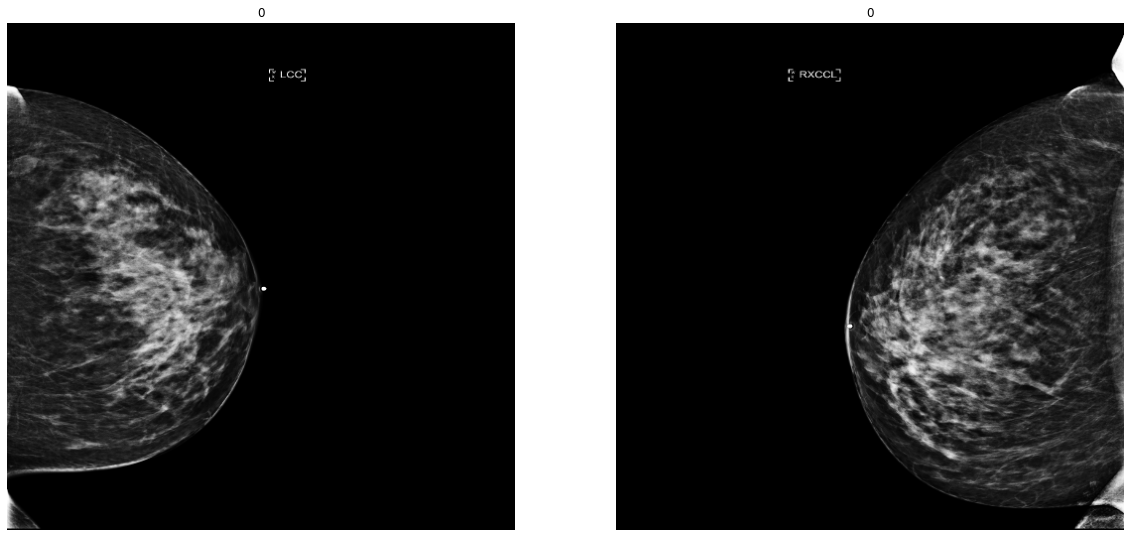

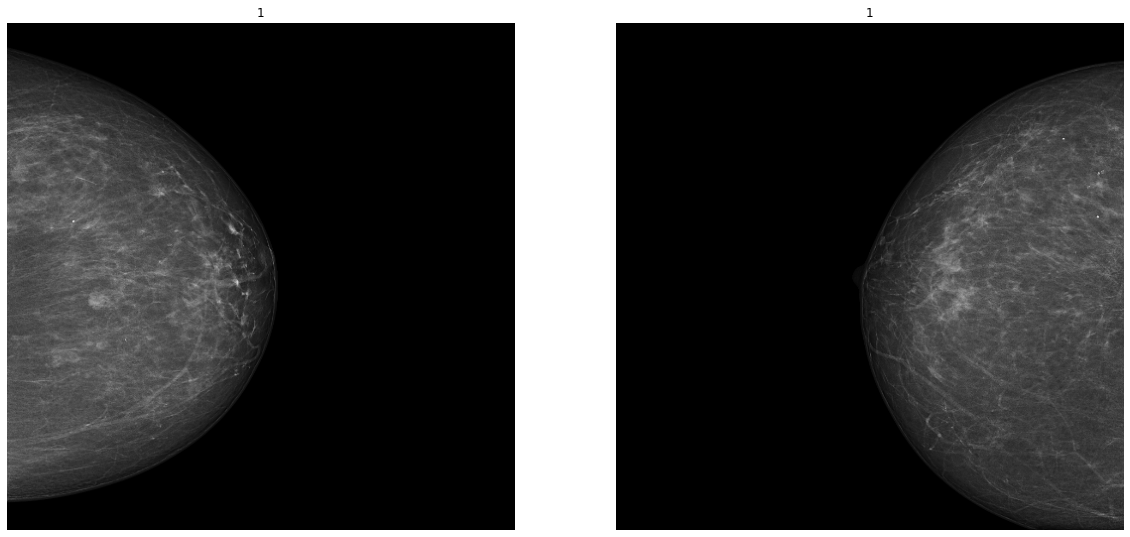

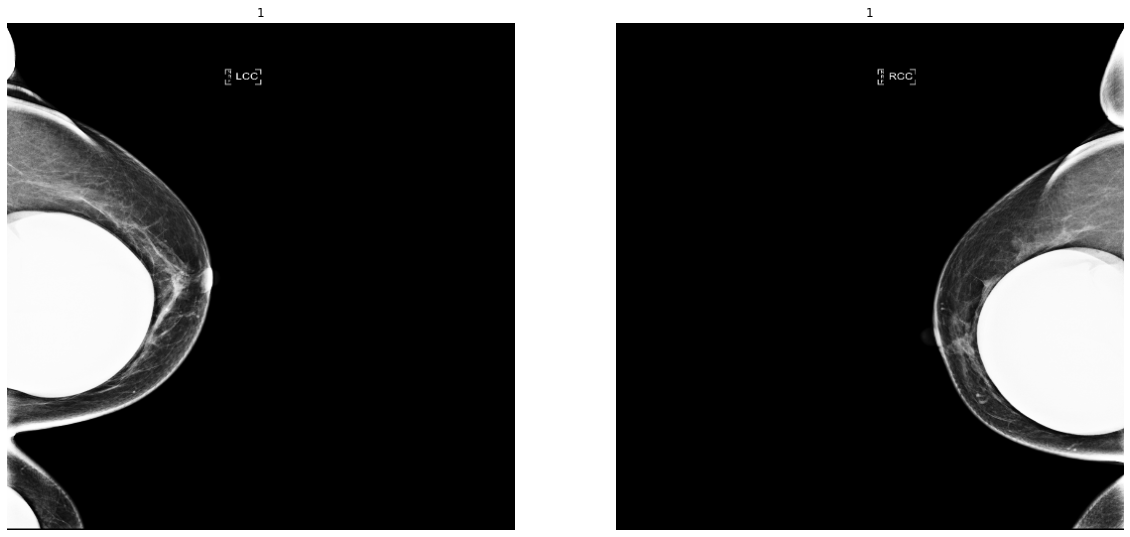

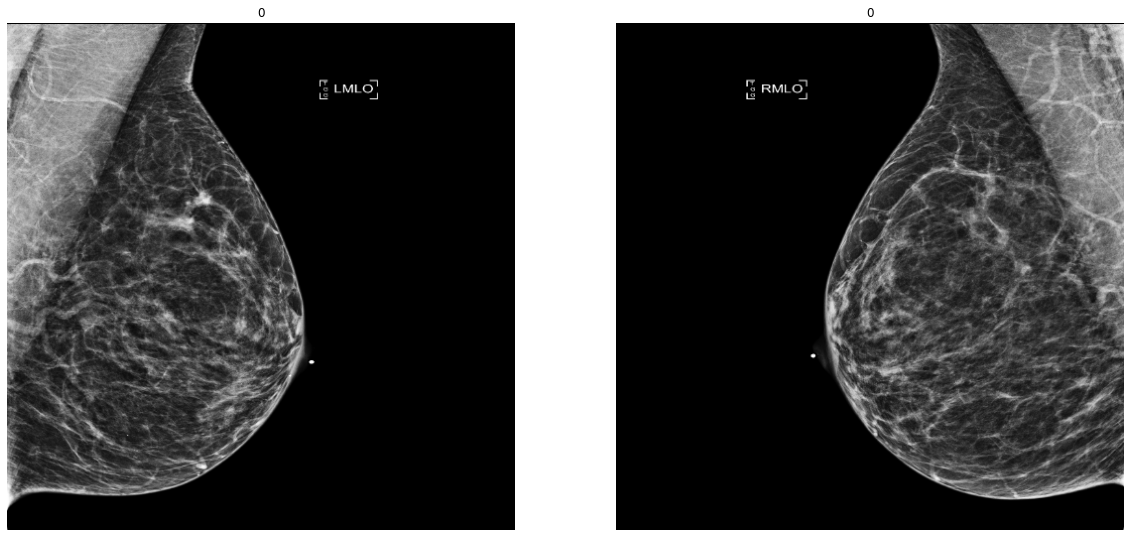

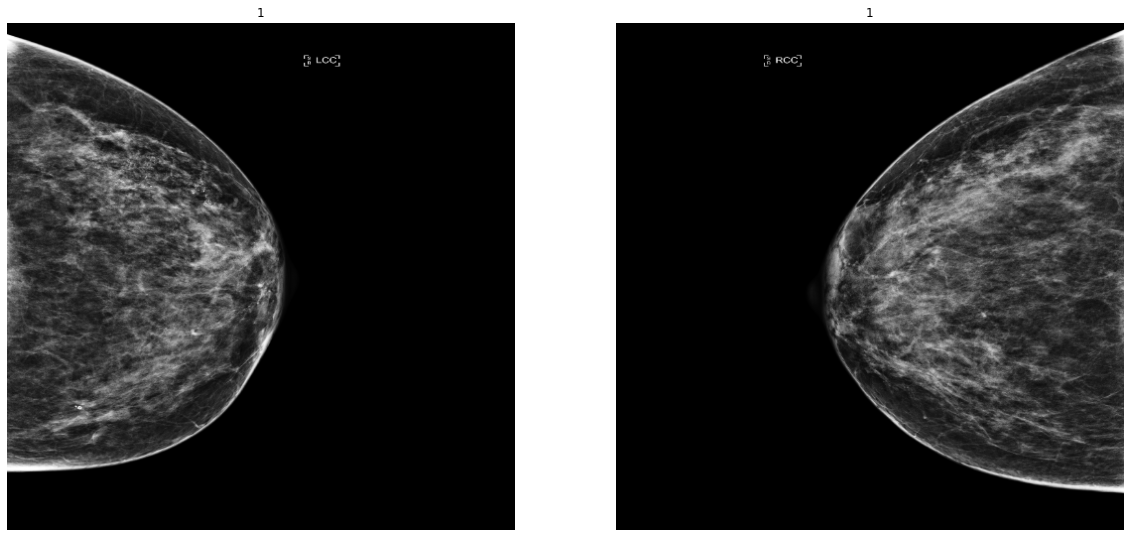

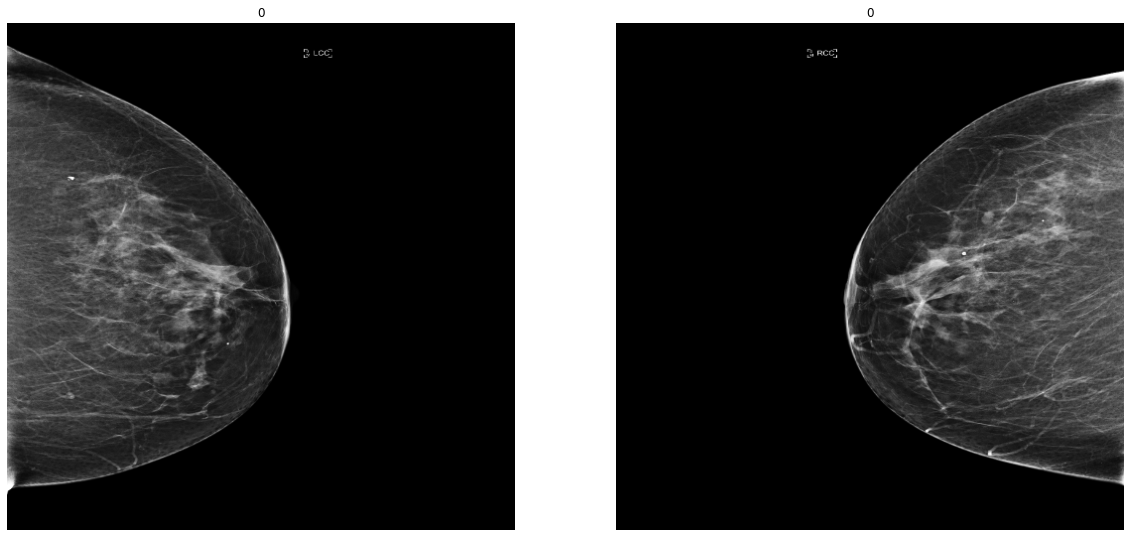

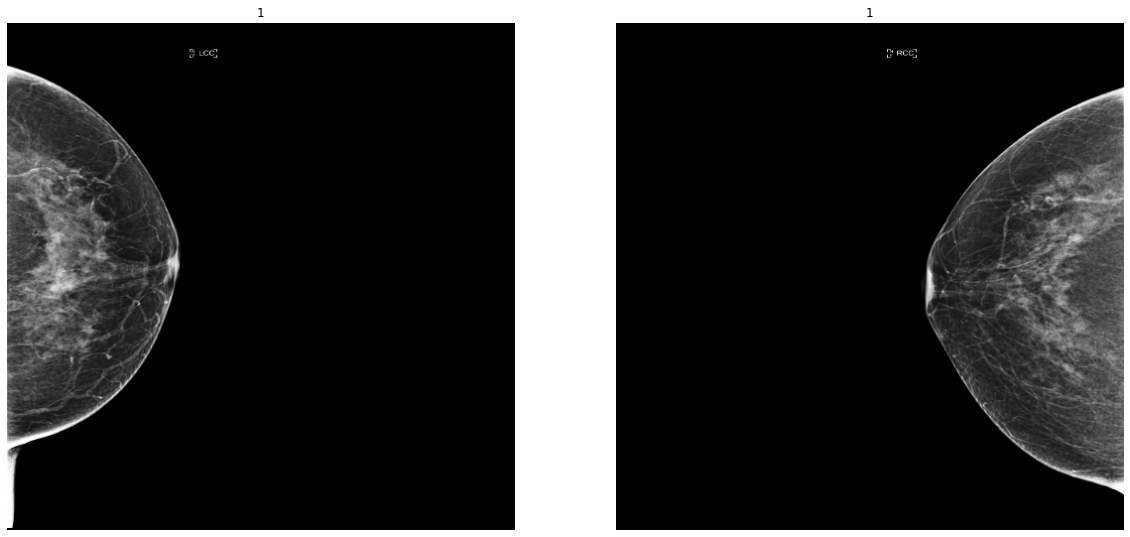

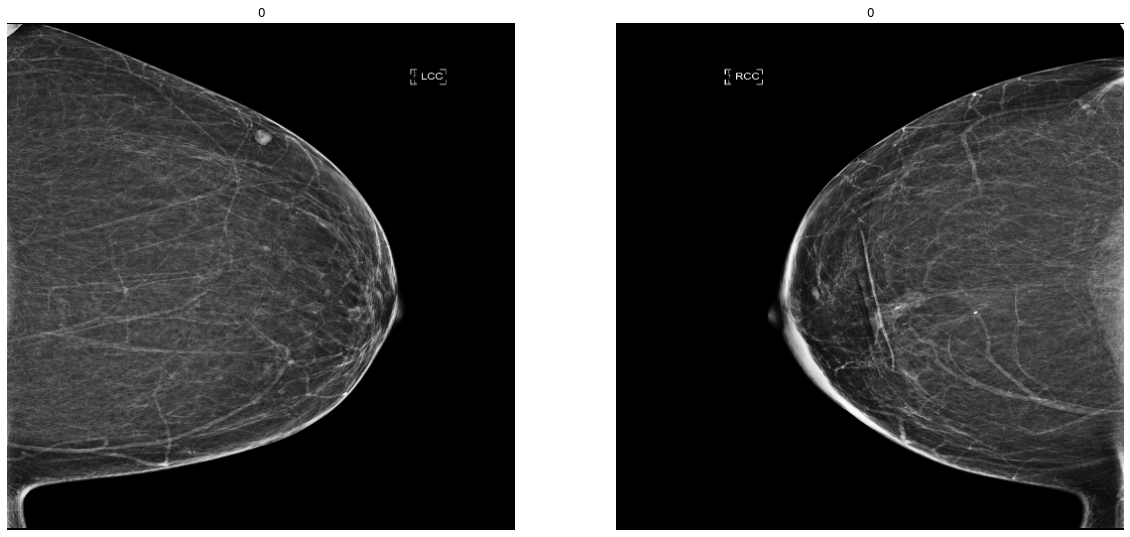

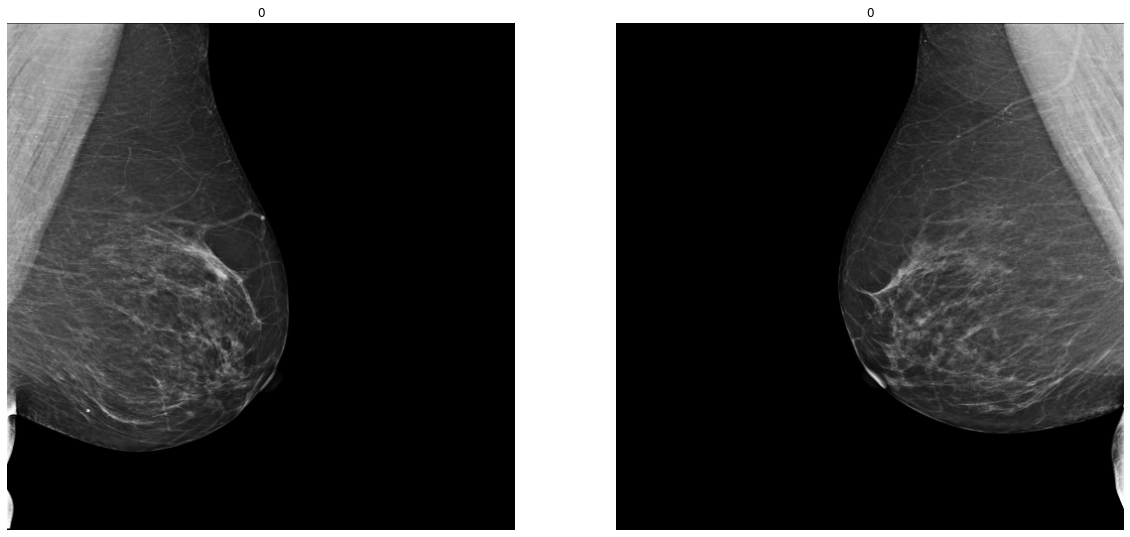

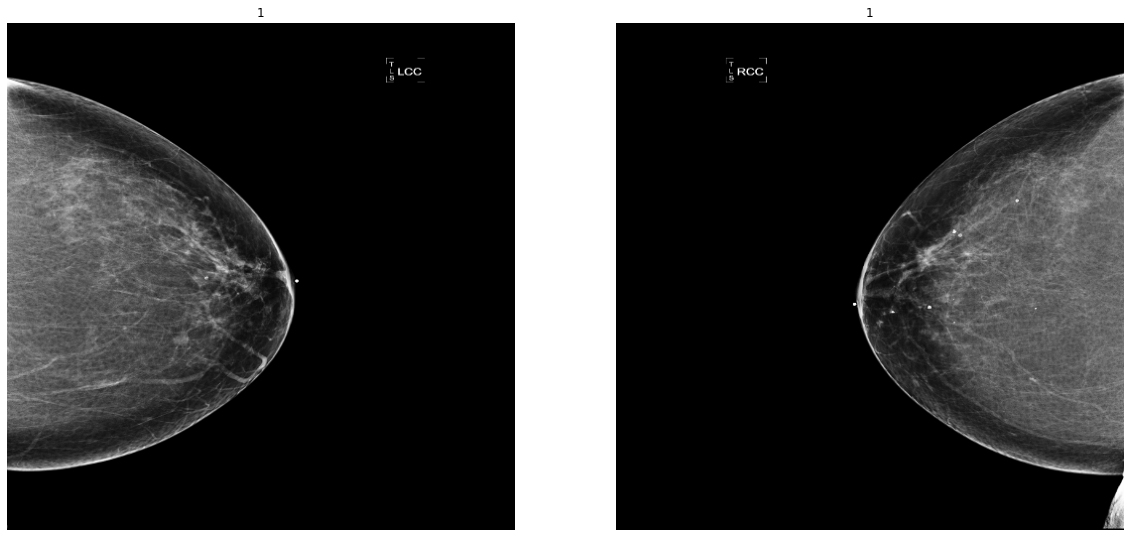

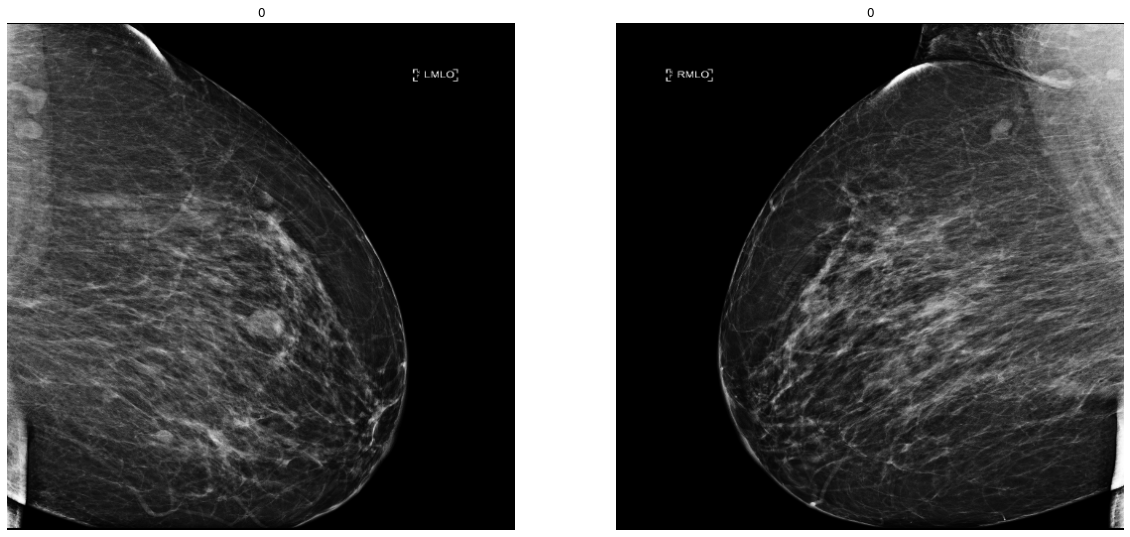

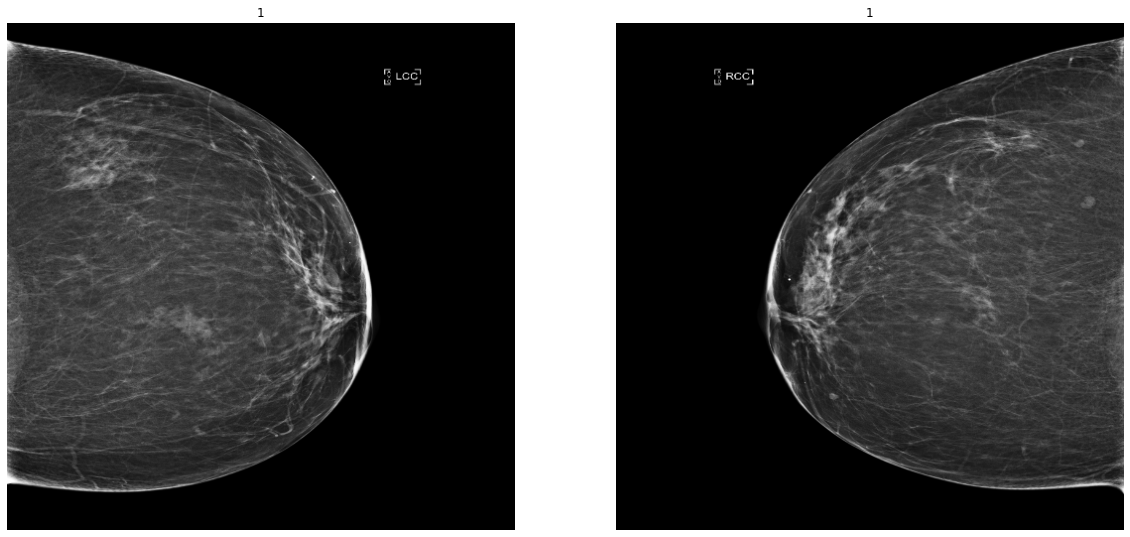

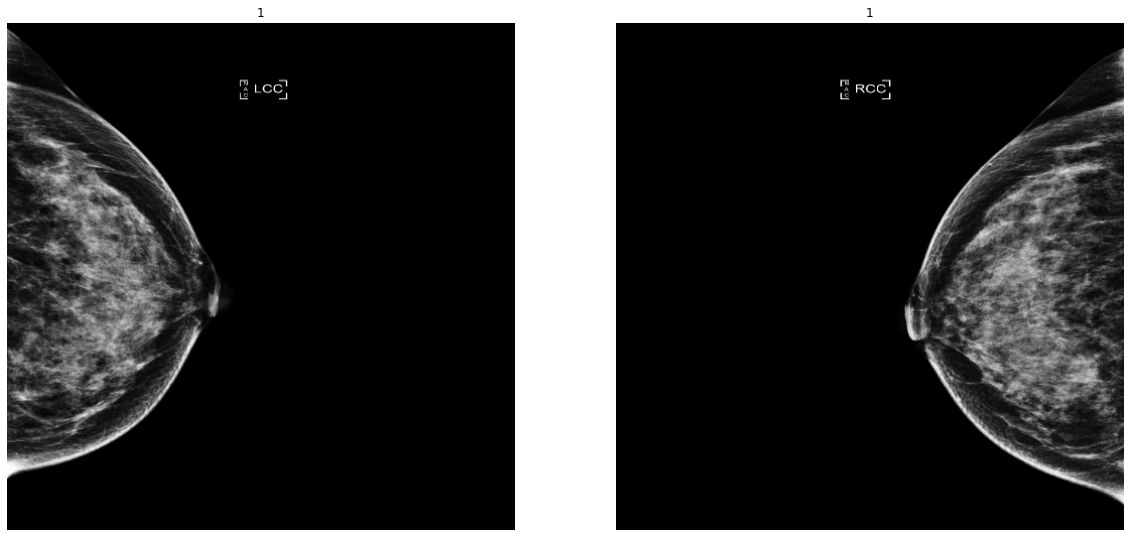

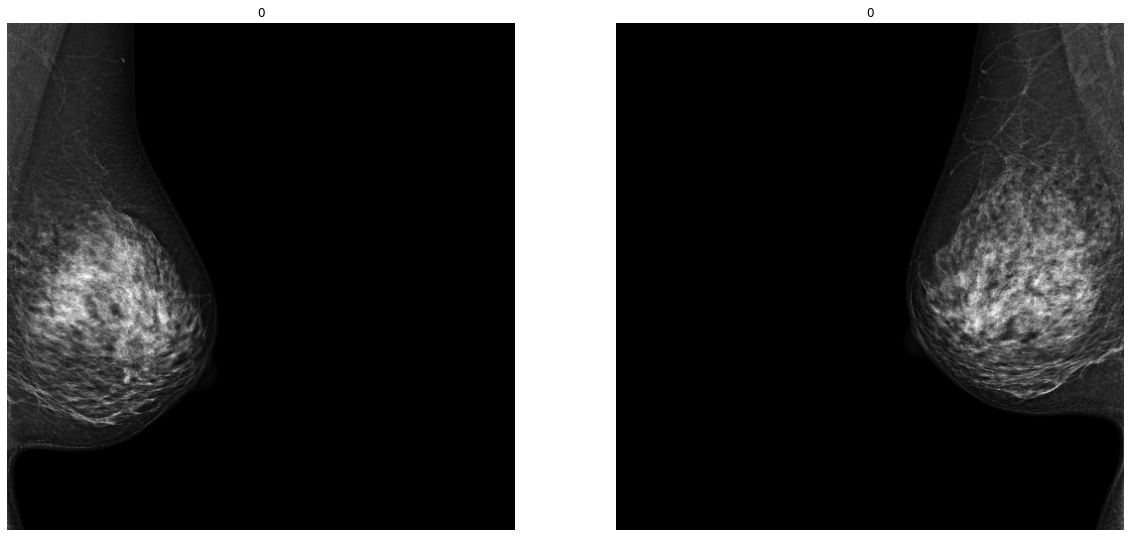

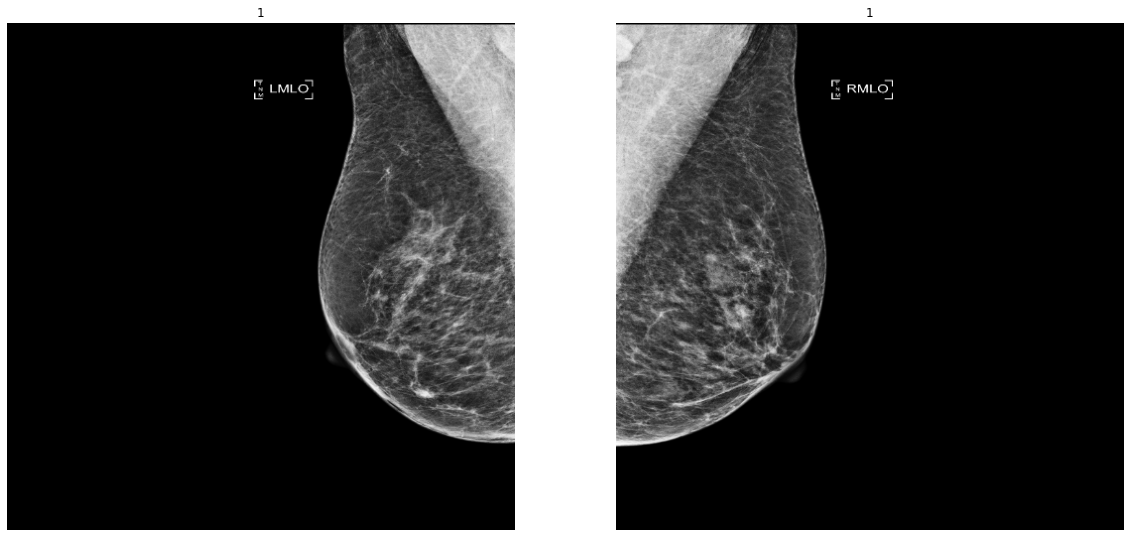

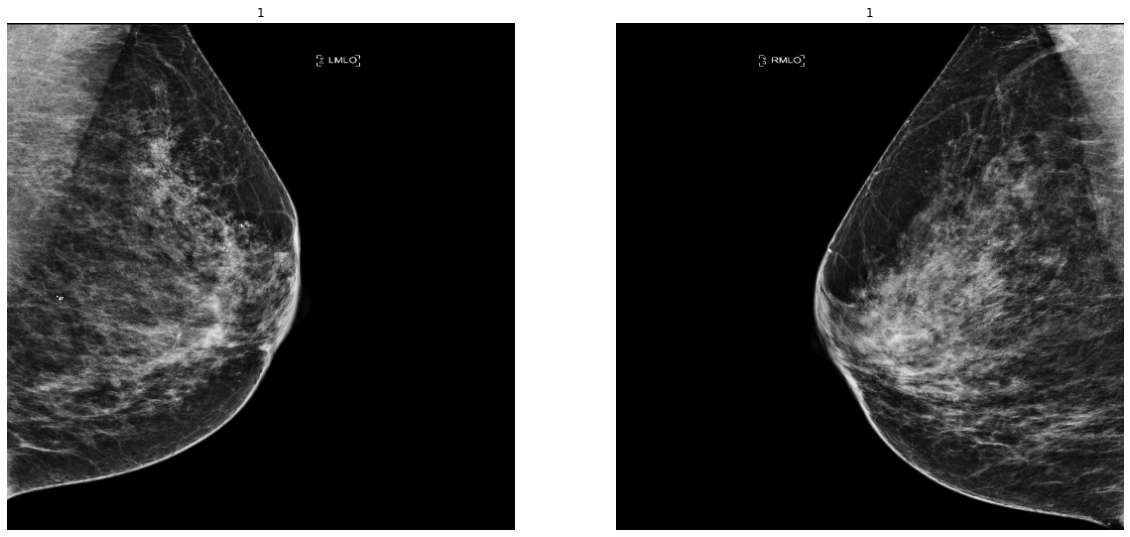

In [17]:
# initialize a figure
print("[INFO] visualizing the first batch of the dataset...")
print("batch without augmentation")

# loop over the batch size
for i in range(0, BS):
    # grab the image and label from the batch
    (image1, image2, label) = (batch[0][0][i], batch[0][1][i], batch[1][i])
    pair= (image1, image2)
    fig = plt.figure(figsize=(20, 20))
    for j in range (2):
        # create a subplot and plot the image and label
        ax1 = plt.subplot(1, 2, j+1)
        ax1.imshow(pair[j].numpy().squeeze(), cmap='gray')
        plt.title(label.numpy())
        plt.axis("off")

### tensorflow siamese network

In [26]:
IMG_SHAPE = (512,512,1)
BATCH_SIZE = 16
EPOCHS = 100
# define the path to the base output directory
BASE_OUTPUT = "./output"

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
def build_siamese_model(inputShape):
    '''
    Function to construct the twin CNNs
    ------
    Params:
    inputShape: (width, height, channels)
    embeddingDim: feature vector size (output of the fully connected layer)
    '''
    # specify the inputs for the feature extractor network
    inputs = Input((inputShape))
    # define the first set of CONV => RELU => POOL
    x = Conv2D(24, (7, 7), padding="same", activation="relu")(inputs) #, kernel_regularizer=l2(0.0005)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same")(x)
    # second set of CONV => RELU => POOL 
    x = Conv2D(64, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same")(x)
    # two consecutive CONV layers
    x= Conv2D(96,(3,3), padding="same", activation="relu")(x)
    x= Conv2D(96,(3,3), padding="same", activation="relu")(x)
    # final set of CONV => RELU => POOL 
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same")(x)
    # flatten to get the feature vector
    #x = Flatten()(x)
    # using global average pooling instead of flatten to reduce no of trainable parameters
    x = GlobalAveragePooling2D()(x)
#     x = Dense(512, activation="relu")(x) #, kernel_regularizer=l2(0.01)
#     x = Dropout(0.5)(x)
#     # second fully connected layer ==> RELU ==> dropout
#     x = Dense(512, activation="relu")(x)
#     x = Dropout(0.5)(x)
    # build the model
    model = Model(inputs, outputs=x)
    # return the model to the calling function
    return model

In [29]:
def build_metric_model(featureShape = 128): #featureShape = 128 in CNN
    '''
    Function to build the fully connected classifier
    -------
    Params:
    Concatenated feature shape
    '''
    # input layer
    inputs = Input(shape=(featureShape,))
    # first fully connected layer ==> RELU ==> dropout
    x = Dense(512, activation="relu")(inputs) #, kernel_regularizer=l2(0.01)
    x = Dropout(0.5)(x)
    # second fully connected layer ==> RELU ==> dropout
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    # final fully connected layer with 2 outputs ==> Softmax
    #outputs = Dense(2, activation="softmax")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    # build the model
    model = Model(inputs, outputs=outputs,name='metric_model')
    # return the model to the calling function
    return model

In [30]:
# build the final network
def build_model():
    print("[INFO] building MatchNet network...")
    imgA = Input(shape=IMG_SHAPE)
    imgB = Input(shape=IMG_SHAPE)
    featureExtractor = build_siamese_model(IMG_SHAPE)
    #featureExtractor = late_merge(IMG_SHAPE)
    #featureExtractor = get_cnn_model(fold)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)
    # concatenate output features
    concat_feats = tf.keras.layers.Concatenate()([featsA, featsB])
    # construct the metric network
    metricNetwork = build_metric_model(128)
    metric_output = metricNetwork(concat_feats)
    # Final MatchNet model
    model = Model(inputs=[imgA, imgB], outputs=metric_output)
#     distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([featsA, featsB])
#     #distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([featsA, featsB])
#     model = Model(inputs=[imgA, imgB], outputs=distance)
    return model

In [31]:
def plot_training(H, plotPath, ifLoss):
    # construct a plot that plots and saves the training history
    plt.figure()
    plt.style.use("ggplot")
    if ifLoss:
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
    else:
        plt.plot(H.history["accuracy"], label="train_acc")
        plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [32]:
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

[INFO] building MatchNet network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/5


2023-01-15 21:12:15.961735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2023-01-15 21:12:17.059511: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-15 21:12:17.059775: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-15 21:12:17.147832: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

30/30 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.4583 - auc_1: 0.4674
Epoch 00001: loss improved from inf to 0.69582, saving model to ./output


2023-01-15 21:12:27.170783: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./output/assets
30/30 [==============================] - 17s 324ms/step - loss: 0.6958 - accuracy: 0.4583 - auc_1: 0.4674 - val_loss: 0.6932 - val_accuracy: 0.4875 - val_auc_1: 0.5000
Epoch 2/5
30/30 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5146 - auc_1: 0.5147
Epoch 00002: loss improved from 0.69582 to 0.69265, saving model to ./output
INFO:tensorflow:Assets written to: ./output/assets
30/30 [==============================] - 9s 294ms/step - loss: 0.6926 - accuracy: 0.5146 - auc_1: 0.5147 - val_loss: 0.6939 - val_accuracy: 0.4875 - val_auc_1: 0.5000
Epoch 3/5
30/30 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5063 - auc_1: 0.4769
Epoch 00003: loss did not improve from 0.69265
30/30 [==============================] - 7s 230ms/step - loss: 0.6936 - accuracy: 0.5063 - auc_1: 0.4769 - val_loss: 0.6938 - val_accuracy: 0.4875 - val_auc_1: 0.5000
Epoch 4/5
30/30 [==============================] - ETA

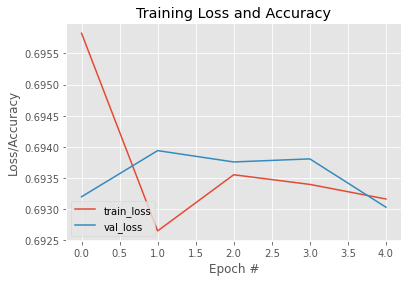

In [33]:
# save path
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])

model = build_model()
# compile the model
print("[INFO] compiling model...")
decay_steps = 1000
initial_learning_rate = 0.001
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, decay_steps)
opt = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)
model.compile(loss='binary_crossentropy', optimizer=opt ,metrics=["accuracy", tf.keras.metrics.AUC()])
# train the model
print("[INFO] training model...")
# checkpoint to save model while training
checkpoint = ModelCheckpoint(BASE_OUTPUT, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks_list = [checkpoint, es\
                  ,tensorboard_callback(os.path.sep.join([BASE_OUTPUT,"Tensorboard"]),"model")]
# start training
history = model.fit(
    trainDS,
    validation_data=(valDS),
    batch_size=BATCH_SIZE, 
    epochs= 5,
    callbacks= callbacks_list)

print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(model.history, os.path.sep.join([BASE_OUTPUT, "plot_loss_siamese.png"]), True)